In [8]:
import sys
# sys.path.insert(0, '../../Utilities/')
from mpl_toolkits import mplot3d
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
# tf.enable_eager_execution()
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [9]:
class PhysicsInformedNN3:
    # Initialize the class
    def __init__(self, X, u, layers, lb, ub, q):
        
        self.loss_array= []
        self.lambda_array= []
        
        
        self.lb = lb
        self.ub = ub
        
        self.x = X[:,0:1]
        self.t = X[:,1:2]
        self.u = u
        
        self.layers = layers
        self.q = q
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([1.0], dtype=tf.float32)
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
                
        self.u_pred = self.net_u(self.x_tf, self.t_tf)
        self.f_pred = self.net_f(self.x_tf, self.t_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = (X - self.lb)/(self.ub - self.lb) 
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.math.sigmoid(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):  
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x, t):
        lambda_1 = self.lambda_1        
        q = self.q 
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
#         f= q+ lambda_1*u_x
        f = q - lambda_1*(tf.math.sqrt(tf.math.square(u_x) + tf.math.square(u_t))) 
        
        return f
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, lambda_1, lambda_2))
        
        
    def train(self, nIter):
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = self.sess.run(self.lambda_2)
                
                self.loss_array.append(loss_value)
                self.lambda_array.append(lambda_1_value)
#                 lolz= self.sess.run(self.net_f(self.x_tf,self.t_tf) , tf_dict)
                print('It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
#                 print(lolz)
                start_time = time.time()
        
#         self.optimizer_Adam.minimize(self.loss)
        
        
#         self.optimizer.minimize(self.sess,
#                                 feed_dict = tf_dict,
#                                 fetches = [self.loss, self.lambda_1, self.lambda_2],
#                                 loss_callback = self.callback)
        
        
    def predict(self, X_star):
        
        tf_dict = {self.x_tf: X_star[:,0:1], self.t_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        f_star = self.sess.run(self.f_pred, tf_dict)
        
        return u_star, f_star

In [10]:
df= pd.read_csv(r"C:\Users\Omkar\Downloads\composite_.csv")

In [11]:
q_z= df.loc[:,["Directional Heat Flux (Z)" ]] 

In [7]:
q_z.shape

(38445, 1)

In [12]:
q_z_new=np.array(q_z)

In [14]:
q_z_new_sq=np.square(q_z_new)

In [15]:
q_x= df.loc[:,["Directional Heat Flux (X)" ]] 

In [16]:
q_x_new=np.array(q_x)

In [17]:
q_x_new_sq=np.square(q_x_new)

In [18]:
q_final = np.sqrt((q_x_new_sq+q_z_new_sq))

In [19]:
x_y=df.loc[:,["X Location (m)","Z Location (m)" ]] 

In [20]:
x_y=np.array(x_y)

In [22]:
u=df.loc[:,"Temperature (K)"]

In [23]:
u=np.array(u)

In [25]:
u=u.reshape(38445,1)

In [26]:
N_u_1=3000
layers1 = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

In [27]:
lb1 = x_y.min(0)
ub1 = x_y.max(0)

In [28]:
idx = np.random.choice(x_y.shape[0], N_u_1, replace=False)
X_u_train = x_y[idx,:]
u_train = u[idx,:]
# q = scaled_q[idx,:]
q_= q_final[idx,:]
q_t= tf.convert_to_tensor(q_,dtype=tf.float32)
# q_= tf.convert_to_tensor(q,dtype=tf.float32)


In [29]:
model = PhysicsInformedNN3(X_u_train, u_train, layers1, lb1, ub1 , q_t)
model.train(10000)

Device mapping:

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

It: 0, Loss: 7.327e-01, Lambda_1: 0.001, Lambda_2: 1.000000, Time: 0.91
It: 10, Loss: 7.298e-01, Lambda_1: 0.010, Lambda_2: 1.000000, Time: 0.15
It: 20, Loss: 7.297e-01, Lambda_1: 0.020, Lambda_2: 1.000000, Time: 0.10
It: 30, Loss: 7.297e-01, Lambda_1: 0.030, Lambda_2: 1.000000, Time: 0.10
It: 40, Loss: 7.297e-01, Lambda_1: 0.041, Lambda_2: 1.000000, Time: 0.11
It: 50, Loss: 7.297e-01, Lambda_1: 0.052, Lambda_2: 1.000000, Time: 0.09
It: 60, Loss: 7.297e-01, Lambda_1: 0.065, Lambda_2: 1.000000, Time: 0.10
It: 70, Loss: 7.297e-01, Lambda_1: 0.078, Lambda_2: 1.000000, Time: 0.11
It: 80, Loss: 7.297e-01, Lambda_1: 0

It: 1060, Loss: 3.030e-01, Lambda_1: 1.012, Lambda_2: 1.000000, Time: 0.13
It: 1070, Loss: 3.029e-01, Lambda_1: 1.013, Lambda_2: 1.000000, Time: 0.12
It: 1080, Loss: 3.029e-01, Lambda_1: 1.015, Lambda_2: 1.000000, Time: 0.11
It: 1090, Loss: 3.029e-01, Lambda_1: 1.017, Lambda_2: 1.000000, Time: 0.13
It: 1100, Loss: 3.028e-01, Lambda_1: 1.018, Lambda_2: 1.000000, Time: 0.13
It: 1110, Loss: 3.028e-01, Lambda_1: 1.020, Lambda_2: 1.000000, Time: 0.11
It: 1120, Loss: 3.028e-01, Lambda_1: 1.021, Lambda_2: 1.000000, Time: 0.11
It: 1130, Loss: 3.027e-01, Lambda_1: 1.022, Lambda_2: 1.000000, Time: 0.11
It: 1140, Loss: 3.027e-01, Lambda_1: 1.024, Lambda_2: 1.000000, Time: 0.11
It: 1150, Loss: 3.026e-01, Lambda_1: 1.025, Lambda_2: 1.000000, Time: 0.13
It: 1160, Loss: 3.026e-01, Lambda_1: 1.026, Lambda_2: 1.000000, Time: 0.11
It: 1170, Loss: 3.026e-01, Lambda_1: 1.028, Lambda_2: 1.000000, Time: 0.11
It: 1180, Loss: 3.025e-01, Lambda_1: 1.029, Lambda_2: 1.000000, Time: 0.11
It: 1190, Loss: 3.025e-01

It: 2160, Loss: 2.242e-01, Lambda_1: 1.065, Lambda_2: 1.000000, Time: 0.11
It: 2170, Loss: 2.177e-01, Lambda_1: 1.064, Lambda_2: 1.000000, Time: 0.11
It: 2180, Loss: 2.106e-01, Lambda_1: 1.062, Lambda_2: 1.000000, Time: 0.13
It: 2190, Loss: 2.023e-01, Lambda_1: 1.061, Lambda_2: 1.000000, Time: 0.13
It: 2200, Loss: 1.933e-01, Lambda_1: 1.060, Lambda_2: 1.000000, Time: 0.11
It: 2210, Loss: 1.840e-01, Lambda_1: 1.059, Lambda_2: 1.000000, Time: 0.12
It: 2220, Loss: 1.744e-01, Lambda_1: 1.058, Lambda_2: 1.000000, Time: 0.11
It: 2230, Loss: 1.650e-01, Lambda_1: 1.056, Lambda_2: 1.000000, Time: 0.13
It: 2240, Loss: 1.560e-01, Lambda_1: 1.054, Lambda_2: 1.000000, Time: 0.11
It: 2250, Loss: 1.468e-01, Lambda_1: 1.051, Lambda_2: 1.000000, Time: 0.11
It: 2260, Loss: 1.375e-01, Lambda_1: 1.048, Lambda_2: 1.000000, Time: 0.12
It: 2270, Loss: 1.304e-01, Lambda_1: 1.045, Lambda_2: 1.000000, Time: 0.11
It: 2280, Loss: 1.229e-01, Lambda_1: 1.043, Lambda_2: 1.000000, Time: 0.11
It: 2290, Loss: 1.174e-01

It: 3260, Loss: 7.671e-02, Lambda_1: 0.989, Lambda_2: 1.000000, Time: 0.13
It: 3270, Loss: 7.662e-02, Lambda_1: 0.989, Lambda_2: 1.000000, Time: 0.13
It: 3280, Loss: 7.658e-02, Lambda_1: 0.989, Lambda_2: 1.000000, Time: 0.13
It: 3290, Loss: 7.661e-02, Lambda_1: 0.989, Lambda_2: 1.000000, Time: 0.12
It: 3300, Loss: 7.660e-02, Lambda_1: 0.989, Lambda_2: 1.000000, Time: 0.11
It: 3310, Loss: 7.658e-02, Lambda_1: 0.989, Lambda_2: 1.000000, Time: 0.11
It: 3320, Loss: 7.641e-02, Lambda_1: 0.989, Lambda_2: 1.000000, Time: 0.11
It: 3330, Loss: 7.639e-02, Lambda_1: 0.989, Lambda_2: 1.000000, Time: 0.13
It: 3340, Loss: 7.632e-02, Lambda_1: 0.989, Lambda_2: 1.000000, Time: 0.12
It: 3350, Loss: 7.628e-02, Lambda_1: 0.989, Lambda_2: 1.000000, Time: 0.11
It: 3360, Loss: 7.639e-02, Lambda_1: 0.989, Lambda_2: 1.000000, Time: 0.11
It: 3370, Loss: 7.618e-02, Lambda_1: 0.989, Lambda_2: 1.000000, Time: 0.11
It: 3380, Loss: 7.621e-02, Lambda_1: 0.989, Lambda_2: 1.000000, Time: 0.11
It: 3390, Loss: 7.613e-02

It: 4360, Loss: 7.201e-02, Lambda_1: 0.997, Lambda_2: 1.000000, Time: 0.11
It: 4370, Loss: 7.195e-02, Lambda_1: 0.997, Lambda_2: 1.000000, Time: 0.11
It: 4380, Loss: 7.208e-02, Lambda_1: 0.997, Lambda_2: 1.000000, Time: 0.13
It: 4390, Loss: 7.189e-02, Lambda_1: 0.997, Lambda_2: 1.000000, Time: 0.11
It: 4400, Loss: 7.201e-02, Lambda_1: 0.997, Lambda_2: 1.000000, Time: 0.11
It: 4410, Loss: 7.188e-02, Lambda_1: 0.998, Lambda_2: 1.000000, Time: 0.11
It: 4420, Loss: 7.182e-02, Lambda_1: 0.998, Lambda_2: 1.000000, Time: 0.13
It: 4430, Loss: 7.173e-02, Lambda_1: 0.998, Lambda_2: 1.000000, Time: 0.13
It: 4440, Loss: 7.171e-02, Lambda_1: 0.998, Lambda_2: 1.000000, Time: 0.13
It: 4450, Loss: 7.202e-02, Lambda_1: 0.998, Lambda_2: 1.000000, Time: 0.11
It: 4460, Loss: 7.164e-02, Lambda_1: 0.998, Lambda_2: 1.000000, Time: 0.11
It: 4470, Loss: 7.167e-02, Lambda_1: 0.998, Lambda_2: 1.000000, Time: 0.13
It: 4480, Loss: 7.157e-02, Lambda_1: 0.998, Lambda_2: 1.000000, Time: 0.13
It: 4490, Loss: 7.165e-02

It: 5460, Loss: 6.736e-02, Lambda_1: 1.001, Lambda_2: 1.000000, Time: 0.11
It: 5470, Loss: 6.727e-02, Lambda_1: 1.001, Lambda_2: 1.000000, Time: 0.11
It: 5480, Loss: 6.715e-02, Lambda_1: 1.001, Lambda_2: 1.000000, Time: 0.11
It: 5490, Loss: 6.719e-02, Lambda_1: 1.001, Lambda_2: 1.000000, Time: 0.13
It: 5500, Loss: 6.699e-02, Lambda_1: 1.001, Lambda_2: 1.000000, Time: 0.12
It: 5510, Loss: 6.684e-02, Lambda_1: 1.001, Lambda_2: 1.000000, Time: 0.11
It: 5520, Loss: 6.675e-02, Lambda_1: 1.001, Lambda_2: 1.000000, Time: 0.11
It: 5530, Loss: 6.680e-02, Lambda_1: 1.001, Lambda_2: 1.000000, Time: 0.13
It: 5540, Loss: 6.693e-02, Lambda_1: 1.001, Lambda_2: 1.000000, Time: 0.13
It: 5550, Loss: 6.674e-02, Lambda_1: 1.001, Lambda_2: 1.000000, Time: 0.10
It: 5560, Loss: 6.645e-02, Lambda_1: 1.001, Lambda_2: 1.000000, Time: 0.11
It: 5570, Loss: 6.634e-02, Lambda_1: 1.001, Lambda_2: 1.000000, Time: 0.11
It: 5580, Loss: 6.644e-02, Lambda_1: 1.001, Lambda_2: 1.000000, Time: 0.13
It: 5590, Loss: 6.619e-02

It: 6560, Loss: 5.362e-02, Lambda_1: 0.972, Lambda_2: 1.000000, Time: 0.11
It: 6570, Loss: 5.405e-02, Lambda_1: 0.970, Lambda_2: 1.000000, Time: 0.13
It: 6580, Loss: 5.192e-02, Lambda_1: 0.969, Lambda_2: 1.000000, Time: 0.13
It: 6590, Loss: 5.189e-02, Lambda_1: 0.968, Lambda_2: 1.000000, Time: 0.13
It: 6600, Loss: 5.164e-02, Lambda_1: 0.968, Lambda_2: 1.000000, Time: 0.11
It: 6610, Loss: 5.148e-02, Lambda_1: 0.968, Lambda_2: 1.000000, Time: 0.11
It: 6620, Loss: 5.136e-02, Lambda_1: 0.968, Lambda_2: 1.000000, Time: 0.13
It: 6630, Loss: 5.123e-02, Lambda_1: 0.968, Lambda_2: 1.000000, Time: 0.12
It: 6640, Loss: 5.111e-02, Lambda_1: 0.967, Lambda_2: 1.000000, Time: 0.11
It: 6650, Loss: 5.100e-02, Lambda_1: 0.967, Lambda_2: 1.000000, Time: 0.11
It: 6660, Loss: 5.090e-02, Lambda_1: 0.967, Lambda_2: 1.000000, Time: 0.13
It: 6670, Loss: 5.188e-02, Lambda_1: 0.967, Lambda_2: 1.000000, Time: 0.13
It: 6680, Loss: 5.080e-02, Lambda_1: 0.966, Lambda_2: 1.000000, Time: 0.11
It: 6690, Loss: 5.057e-02

It: 7660, Loss: 4.415e-02, Lambda_1: 0.928, Lambda_2: 1.000000, Time: 0.12
It: 7670, Loss: 4.383e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.11
It: 7680, Loss: 4.380e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.13
It: 7690, Loss: 4.373e-02, Lambda_1: 0.928, Lambda_2: 1.000000, Time: 0.13
It: 7700, Loss: 4.367e-02, Lambda_1: 0.928, Lambda_2: 1.000000, Time: 0.13
It: 7710, Loss: 4.361e-02, Lambda_1: 0.928, Lambda_2: 1.000000, Time: 0.13
It: 7720, Loss: 4.357e-02, Lambda_1: 0.928, Lambda_2: 1.000000, Time: 0.11
It: 7730, Loss: 4.367e-02, Lambda_1: 0.928, Lambda_2: 1.000000, Time: 0.11
It: 7740, Loss: 4.581e-02, Lambda_1: 0.927, Lambda_2: 1.000000, Time: 0.12
It: 7750, Loss: 4.422e-02, Lambda_1: 0.926, Lambda_2: 1.000000, Time: 0.11
It: 7760, Loss: 4.353e-02, Lambda_1: 0.926, Lambda_2: 1.000000, Time: 0.11
It: 7770, Loss: 4.341e-02, Lambda_1: 0.926, Lambda_2: 1.000000, Time: 0.13
It: 7780, Loss: 4.330e-02, Lambda_1: 0.926, Lambda_2: 1.000000, Time: 0.12
It: 7790, Loss: 4.325e-02

It: 8760, Loss: 3.996e-02, Lambda_1: 0.909, Lambda_2: 1.000000, Time: 0.10
It: 8770, Loss: 3.973e-02, Lambda_1: 0.909, Lambda_2: 1.000000, Time: 0.10
It: 8780, Loss: 3.934e-02, Lambda_1: 0.908, Lambda_2: 1.000000, Time: 0.11
It: 8790, Loss: 3.944e-02, Lambda_1: 0.908, Lambda_2: 1.000000, Time: 0.09
It: 8800, Loss: 3.954e-02, Lambda_1: 0.908, Lambda_2: 1.000000, Time: 0.09
It: 8810, Loss: 4.004e-02, Lambda_1: 0.908, Lambda_2: 1.000000, Time: 0.10
It: 8820, Loss: 3.923e-02, Lambda_1: 0.907, Lambda_2: 1.000000, Time: 0.09
It: 8830, Loss: 3.927e-02, Lambda_1: 0.907, Lambda_2: 1.000000, Time: 0.09
It: 8840, Loss: 3.924e-02, Lambda_1: 0.907, Lambda_2: 1.000000, Time: 0.10
It: 8850, Loss: 3.944e-02, Lambda_1: 0.907, Lambda_2: 1.000000, Time: 0.09
It: 8860, Loss: 3.982e-02, Lambda_1: 0.907, Lambda_2: 1.000000, Time: 0.10
It: 8870, Loss: 3.896e-02, Lambda_1: 0.906, Lambda_2: 1.000000, Time: 0.09
It: 8880, Loss: 3.923e-02, Lambda_1: 0.906, Lambda_2: 1.000000, Time: 0.12
It: 8890, Loss: 3.916e-02

It: 9860, Loss: 3.602e-02, Lambda_1: 0.890, Lambda_2: 1.000000, Time: 0.13
It: 9870, Loss: 3.596e-02, Lambda_1: 0.890, Lambda_2: 1.000000, Time: 0.12
It: 9880, Loss: 3.593e-02, Lambda_1: 0.890, Lambda_2: 1.000000, Time: 0.12
It: 9890, Loss: 3.590e-02, Lambda_1: 0.890, Lambda_2: 1.000000, Time: 0.12
It: 9900, Loss: 3.601e-02, Lambda_1: 0.891, Lambda_2: 1.000000, Time: 0.12
It: 9910, Loss: 4.393e-02, Lambda_1: 0.890, Lambda_2: 1.000000, Time: 0.13
It: 9920, Loss: 3.648e-02, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.12
It: 9930, Loss: 3.634e-02, Lambda_1: 0.885, Lambda_2: 1.000000, Time: 0.11
It: 9940, Loss: 3.599e-02, Lambda_1: 0.885, Lambda_2: 1.000000, Time: 0.12
It: 9950, Loss: 3.591e-02, Lambda_1: 0.885, Lambda_2: 1.000000, Time: 0.11
It: 9960, Loss: 3.579e-02, Lambda_1: 0.886, Lambda_2: 1.000000, Time: 0.12
It: 9970, Loss: 3.573e-02, Lambda_1: 0.887, Lambda_2: 1.000000, Time: 0.11
It: 9980, Loss: 3.569e-02, Lambda_1: 0.887, Lambda_2: 1.000000, Time: 0.13
It: 9990, Loss: 3.566e-02

In [31]:
arr=[]
for i in range(0,10000):
    if i%10==0:
        arr.append(i)

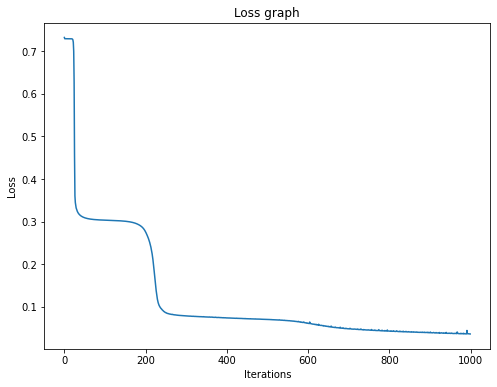

In [32]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Loss')
  
# giving a title to my graph
plt.title('Loss graph')
  
x = arr
y = model.loss_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([0, 10**-2])
plt.show()

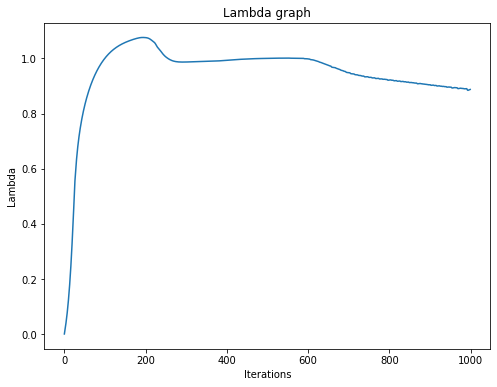

In [33]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Lambda')
  
# giving a title to my graph
plt.title('Lambda graph')
  
x = arr
y = model.lambda_array

ax.plot(y, label='Loss')
# ax.plot(z, color='black', label='Cosine wave')
# ax.set_ylim([5.5, 6])
plt.show()